In [34]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import time

# Option Pricing Simulation in Python

In this notebook, we simulate and compare three methods for pricing European call options:
- Black-Scholes Formula (closed-form)
- Binomial Tree Method (discrete-time lattice)
- Monte Carlo Simulation (stochastic modeling)

We’ll assume a risk-neutral environment and focus on the accuracy and performance of each method.


In [37]:
S0 = 100    # initial stock price
K = 100     # strike price
T = 1       # time to maturity (in years)
r = 0.05    # risk-free rate
sigma = 0.2 # volatility


In [39]:
def black_scholes_call(S0, K, T, r, sigma):
    d1 = (np.log(S0/K) + (r+(sigma**2)/2) * T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price
start = time.time()
bs_price = black_scholes_call(S0, K, T, r, sigma)
end = time.time()

print(f"Black-Scholes Price: {bs_price:.4f} (Time: {end - start:.6f} s)")

Black-Scholes Price: 10.4506 (Time: 0.000000 s)


## Binomial Tree Option Pricing — Theory

### Goal: Compute the fair price of a **European Call Option**

We divide the time to maturity $ T $ into $ N$ steps of length $\Delta t = \frac{T}{N}$, and simulate possible price movements using a recombining tree. $N$ steps of length $ \Delta t = \frac{T}{N} $, and simulate possible price movements using a recombining tree.

---

### 1. **Price Movement Modeling**

In each step:

- The stock can move **up** by a factor $ u$
- Or move **down** by a factor $d $

$$
u = e^{\sigma \sqrt{\Delta t}}, \quad d = \frac{1}{u}
$$

---

### 2. **Risk-neutral Probability**

Under the risk-neutral measure (no arbitrage), the probability of an **upward move** is:

$$
p = \frac{e^{r \Delta t} - d}{u - d}
$$

The probability of a **downward move** is $ 1 - p$.

---

### 3. **Stock Price Tree**

At maturity $T $, the possible stock prices are:

$$
S_j = S_0 \cdot u^j \cdot d^{N - j}, \quad j = 0, 1, ..., N
$$

---

### 4. **Option Payoff at Maturity**

For a **call option**, the payoff is:

$$
C_j = \max(S_j - K, 0)
$$

This gives you an array of option values at the final nodes of the tree.

---

### 5. **Backward Induction (Dynamic Programming)**

Starting from maturity, you work backward through the tree.

At each node:

$$
C_i^{(n)} = e^{-r \Delta t} \cdot \left[ p \cdot C_{i+1}^{(n+1)} + (1 - p) \cdot C_i^{(n+1)} \right]
$$

Where:

- $ C_i^{(n)}$: option price at node $ i$, time $ n$
- $C_{i+1}^{(n+1)} , C_i^{(n+1)}$: option values from the next time step

Repeat until time $ t = 0$. The value at the root of the tree is your **option price**.


In [52]:
N=1000
dt=T/N
def binomial_tree_call(S0, K, T, r, sigma, N):
    u = np.exp(sigma* np.sqrt(dt))
    d = 1/u
    p = (np.exp(r * dt) - d) / (u - d)
    # Build stock price tree
    stock_tree = []
    for i in range(N+1):
        level = []
        for j in range(i+1):
            price = S0 * (u**(i-j)) * (d**j)
            level.append(price)
        stock_tree.append(level)
        
    # Computing the payoffs at maturity 
    option_tree = []
    final_prices = stock_tree[-1]
    final_payoffs = [max(S-K, 0) for S in final_prices]
    option_tree.append(final_payoffs)

    # Backward induction 
    for i in reversed(range(N)):
        level_values = []
        for j in range(i + 1):
            expected = p * option_tree[0][j] + (1 - p) * option_tree[0][j + 1]
            value = np.exp(-r * dt) * expected
            level_values.append(value)
        option_tree.insert(0, level_values)  # prepend this level to the tree
    return option_tree[0][0]

In [54]:
start = time.time()
bi_price = binomial_tree_call(S0, K, T, r, sigma, N)
end = time.time()
print(f"Binomial Model Price: {bi_price:.4f} (Time: {end - start:.6f} s)")

Binomial Model Price: 10.4486 (Time: 2.230034 s)


## Option Pricing Using Monte Carlo Simulation

Monte Carlo methods are a class of numerical techniques that rely on random sampling to estimate mathematical results. In the context of option pricing, they are particularly useful for valuing complex derivatives when analytical solutions are not available.

### Key Idea

To price a European option, we simulate a large number of possible future asset price paths under the **risk-neutral measure** and compute the average discounted payoff.

For a European call option, the payoff is:

$$
\text{Payoff} = \max(S_T - K, 0)
$$

We estimate the option price as:

$$
C_0 \approx e^{-rT} \cdot \frac{1}{M} \sum_{i=1}^M \max(S_T^{(i)} - K, 0)
$$

Where:
- $ M $: Number of simulations
- $ S_T^{(i)} $: Simulated terminal price for the $ i $-th path
- $ r $: Risk-free interest rate
- $ T $: Time to maturity

###  Asset Price Simulation

Under the **risk-neutral geometric Brownian motion**, the terminal stock price is simulated as:

$$
S_T = S_0 \cdot \exp\left((r - \frac{1}{2}\sigma^2)T + \sigma \sqrt{T} Z\right)
$$

Where:
- $ S_0 $: Initial stock price
- $ \sigma $: Volatility
- $ Z \sim \mathcal{N}(0,1) $: Standard normal random variable

### Advantages
- Flexible: Works with any payoff structure.
- Simple to implement.

### Drawbacks
- Computationally intensive.
- Converges slowly compared to lattice methods.

Monte Carlo is especially powerful for pricing **path-dependent options** like Asian, Barrier, or Lookback options.


In [61]:
def monte_carlo_call(S0, K, T, r, sigma, num_simulations=100000):
    Z = np.random.standard_normal(num_simulations)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoff = np.maximum(ST - K, 0)
    price = np.exp(-r * T) * np.mean(payoff)
    return price

start = time.time()
mc_price = monte_carlo_call(S0, K, T, r, sigma)
end = time.time()

print(f"Monte Carlo Price: {mc_price:.4f} (Time: {end - start:.6f} s)")


Monte Carlo Price: 10.4487 (Time: 0.004521 s)


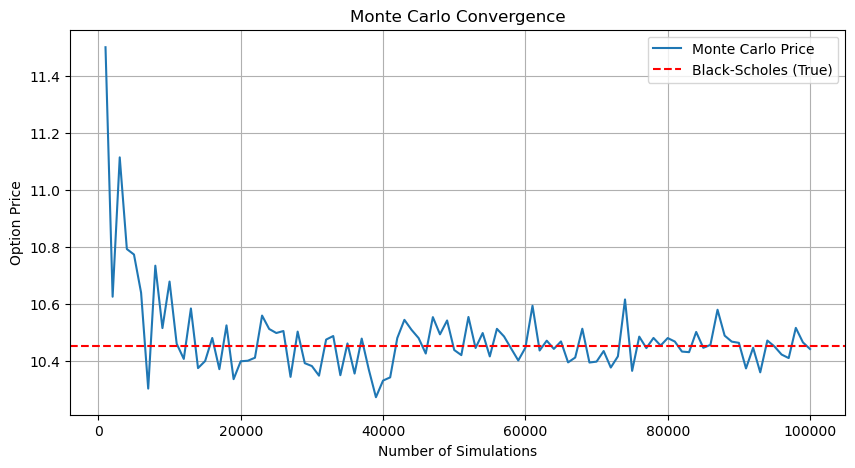

In [65]:
def monte_carlo_convergence(S0, K, T, r, sigma, max_sim=100000, step=1000):
    sims = np.arange(step, max_sim + step, step)
    prices = []

    for n in sims:
        price = monte_carlo_call(S0, K, T, r, sigma, num_simulations=n)
        prices.append(price)

    plt.figure(figsize=(10, 5))
    plt.plot(sims, prices, label='Monte Carlo Price')
    plt.axhline(bs_price, color='red', linestyle='--', label='Black-Scholes (True)')
    plt.xlabel("Number of Simulations")
    plt.ylabel("Option Price")
    plt.title("Monte Carlo Convergence")
    plt.legend()
    plt.grid(True)
    plt.show()

monte_carlo_convergence(S0, K, T, r, sigma)
